In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import tqdm
import spatialcell as cs

In [2]:
adata_sc = sc.read_h5ad("results_example/adata_sc.h5ad")

In [3]:
adatas_final = sc.read_h5ad('results_example/adatas_7.h5ad')
adatas_final

AnnData object with n_obs × n_vars = 37510 × 2475
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
import pickle
with open('results_example/cells_final_7.pkl', 'rb') as file:
    cells_final = pickle.load(file)

In [5]:
import pickle
with open('results_example/so1.pkl', 'rb') as file:
    so = pickle.load(file)

In [6]:
cell_type_final = cs.return_celltype_plot(adatas_final, so)

100%|██████████| 23340/23340 [01:07<00:00, 343.51it/s]


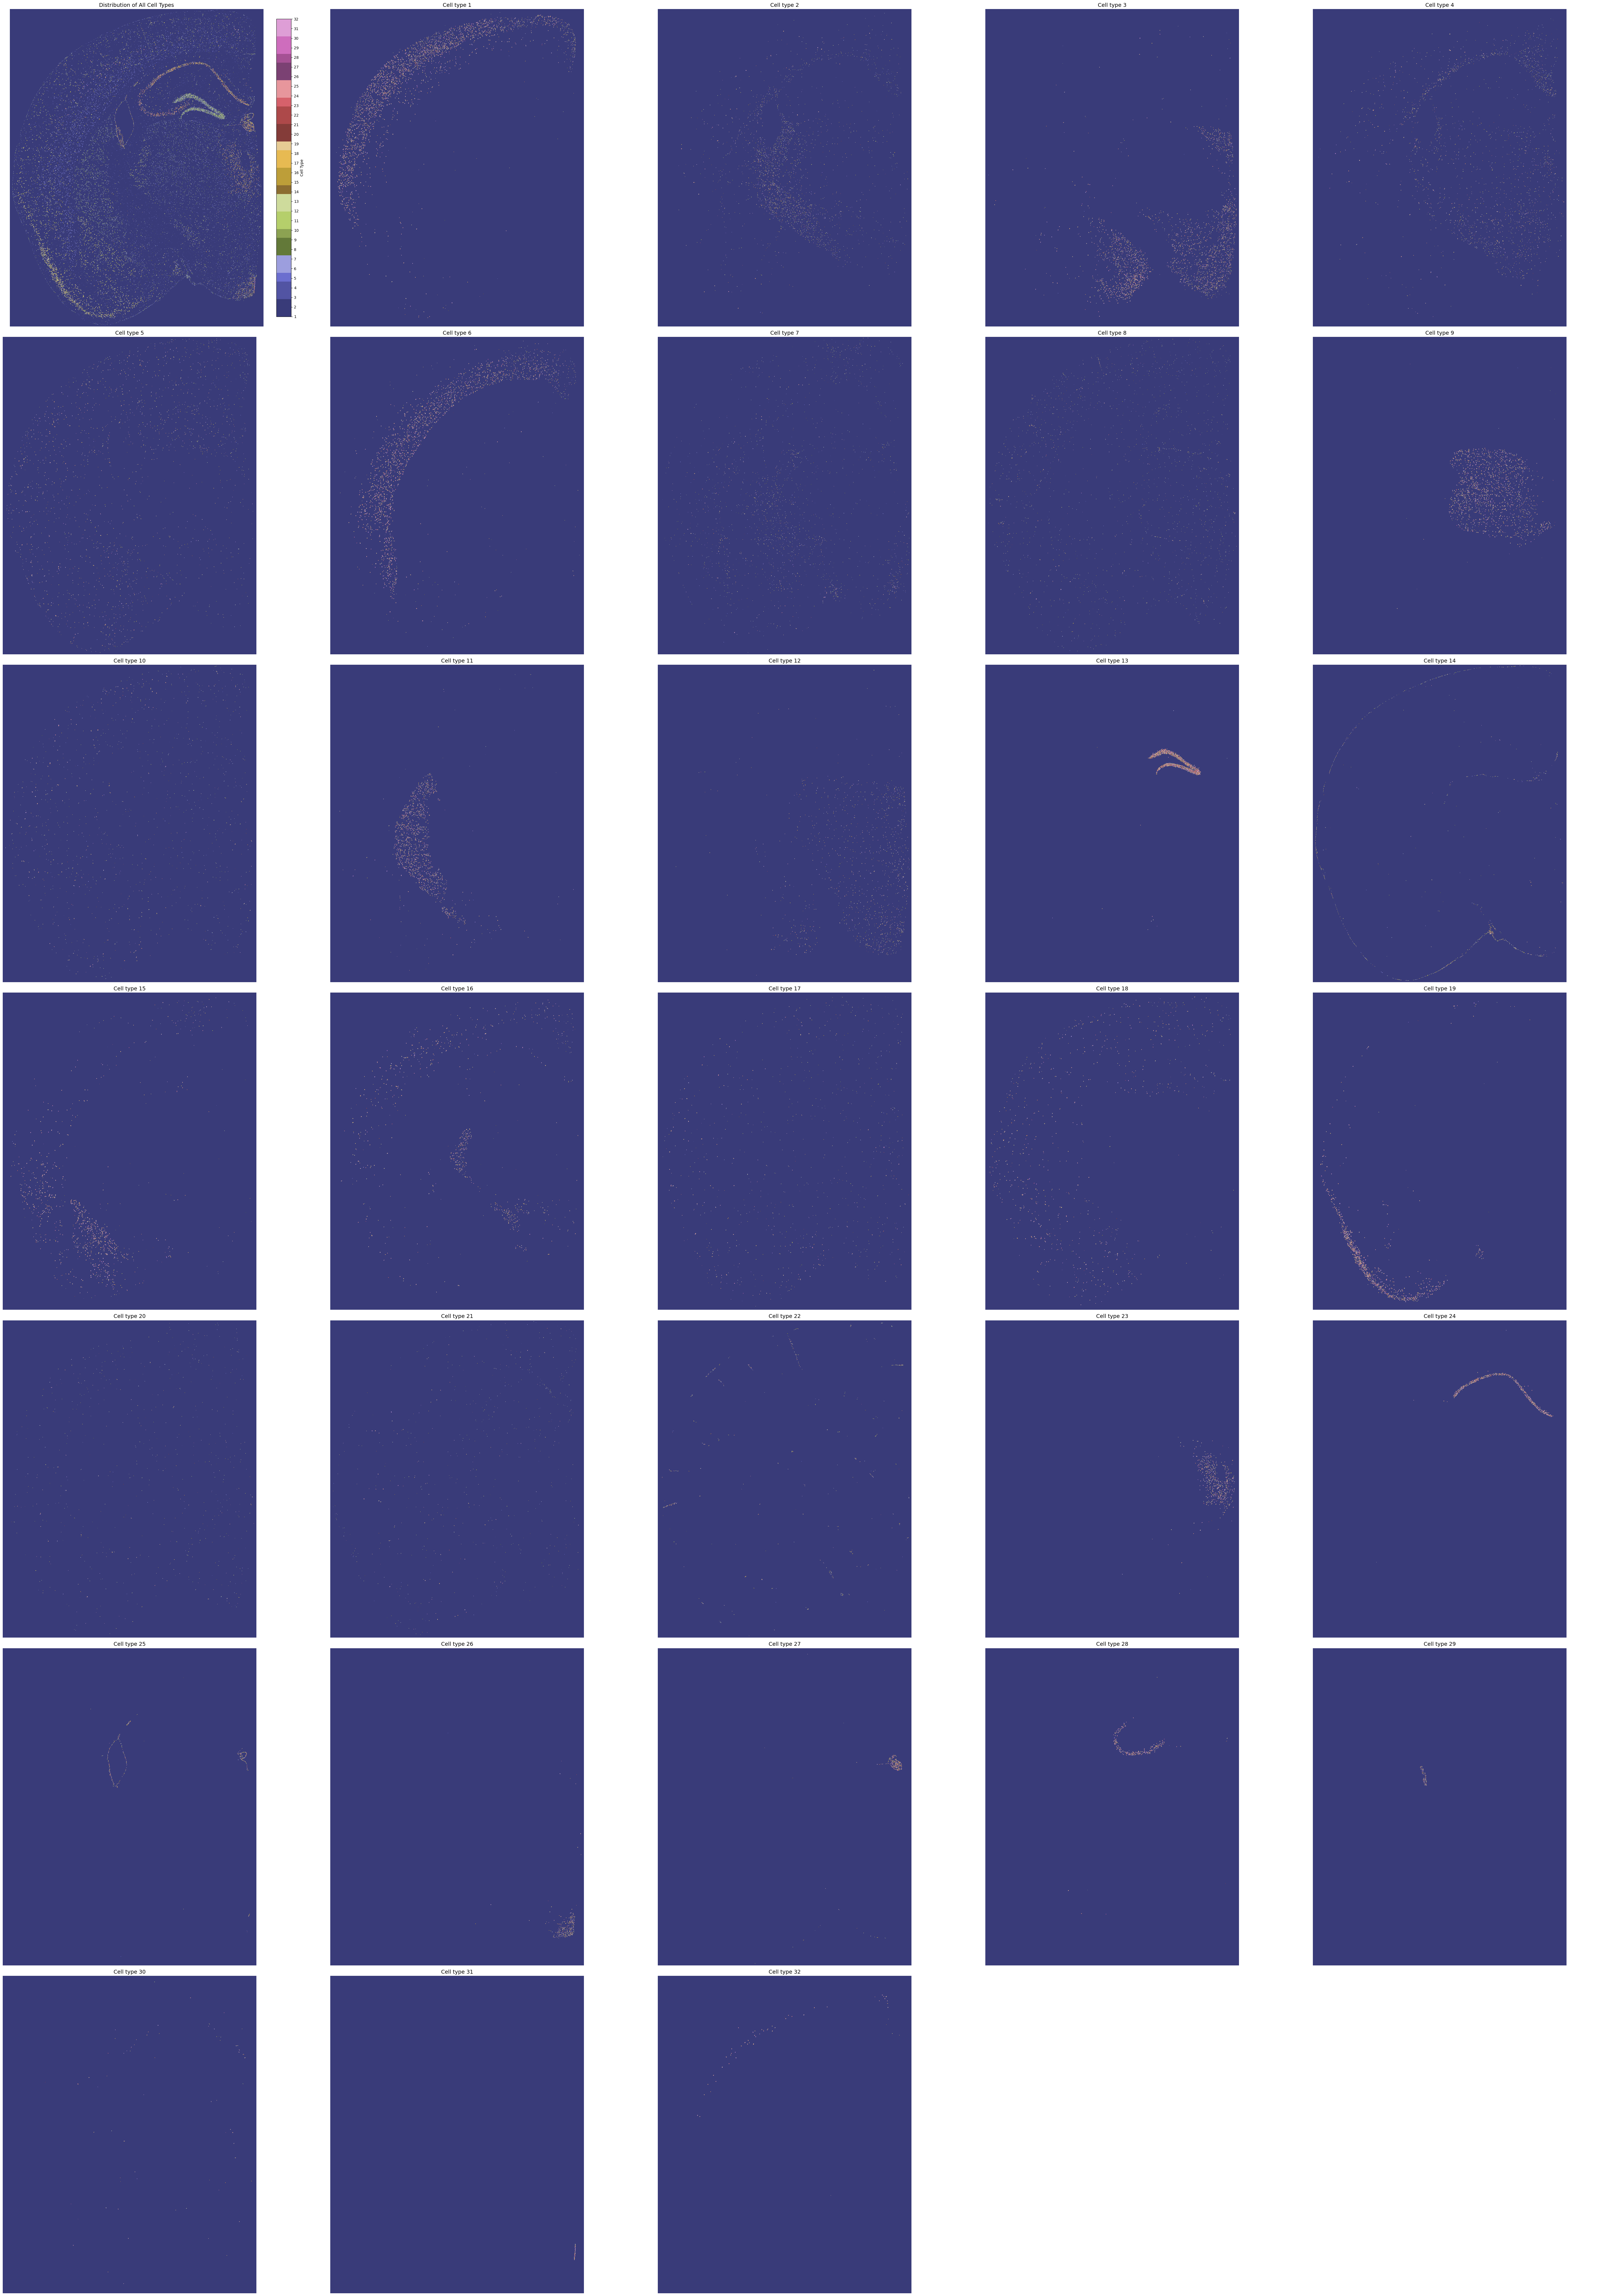

In [7]:
cs.plot_celltype_position(cell_type_final, col_num=5)

100%|██████████| 32/32 [03:55<00:00,  7.37s/it]


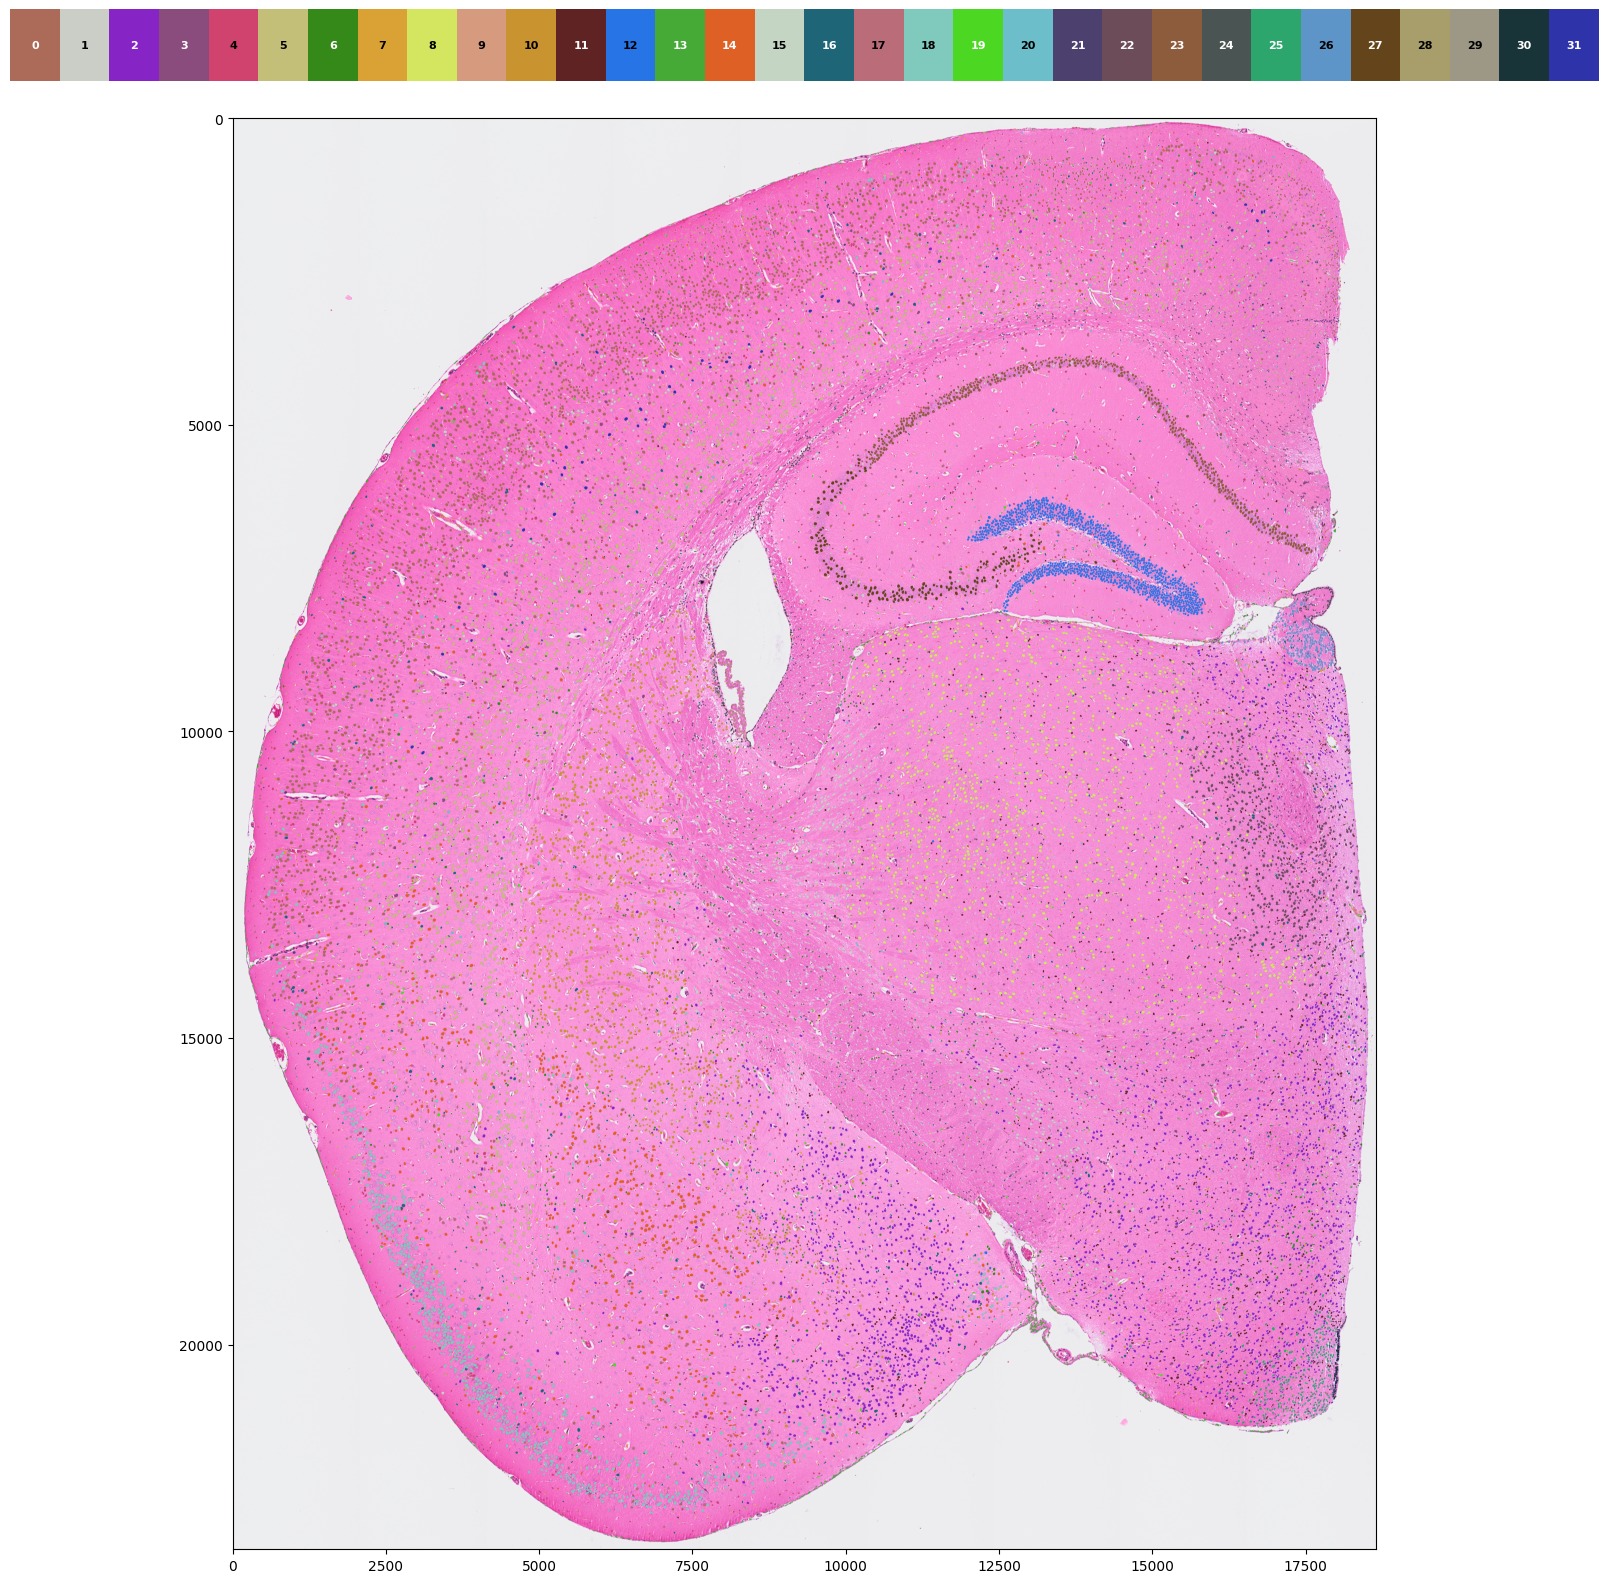

In [8]:
cs.plot_whole(so, cell_type_final,colors = None, save = 'results_example/result_whole_pic.pdf')

In [9]:
with open('results_example/weights_record.pkl', 'rb') as file:
    weights_record = pickle.load(file)

In [10]:
adata = sc.read_10x_mtx('../square_002um/filtered_feature_bc_matrix')
adata = copy.deepcopy(adata[so.df[so.df.in_tissue == 1]['barcode']])
sc.pp.filter_genes(adata, min_counts=1000) 

In [11]:
pct_toml_dic, spots_X_dic, celltypes_dic, cells_X_plus_dic, nonzero_indices_dic, nonzero_indices_toml, cells_before_ml, cells_before_ml_x, groups_combined = cs.make_preparation(cells_final, 
                                                                                                                                                        so, adatas_final, adata, 
                                                                                                                weights_record[7], maximum_cells = 6000)

 31%|███▏      | 422256/1343888 [00:22<00:34, 26480.97it/s]/home/juanru/miniconda3/envs/bidcell/lib/python3.10/site-packages/scipy/sparse/_base.py:699: RuntimeWarning: divide by zero encountered in divide
  return self.astype(np.float64)._mul_scalar(1./other)
100%|██████████| 1343888/1343888 [01:03<00:00, 21181.07it/s]
/home/juanru/Desktop/visuimhd_Data/mousebrain_new/spatialcell/spatialcell/split.py:161: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num(np.rint((A/(A+B)).reshape(1, -1) *  np.array(data_temp[i[0]].todense())), nan=0.0, posinf=0.0, neginf=0.0)
/home/juanru/Desktop/visuimhd_Data/mousebrain_new/spatialcell/spatialcell/split.py:296: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num(np.rint((A/(A+B)).reshape(1, -1) *  np.array(data_temp[spot_id].todense())), nan=0.0, posinf=0.0, neginf=0.0)


In [12]:
with open("results_example/pct_toml_dic.pkl", 'wb') as f:
    pickle.dump(pct_toml_dic, f)

with open("results_example/spots_X_dic.pkl", 'wb') as f:
    pickle.dump(spots_X_dic, f)

with open("results_example/celltypes_dic.pkl", 'wb') as f:
    pickle.dump(celltypes_dic, f)

with open("results_example/nonzero_indices_dic.pkl", 'wb') as f:
    pickle.dump(nonzero_indices_dic, f)

with open("results_example/nonzero_indices_toml.pkl", 'wb') as f:
    pickle.dump(nonzero_indices_toml, f)

In [13]:
with open("results_example/cells_X_plus_dic.pkl", 'wb') as f:
    pickle.dump(cells_X_plus_dic, f)

In [14]:
with open("results_example/cells_before_ml.pkl", 'wb') as f:
    pickle.dump(cells_before_ml, f)

with open("results_example/cells_before_ml_x.pkl", 'wb') as f:
    pickle.dump(cells_before_ml_x, f)

In [15]:
with open("results_example/groups_combined.pkl", 'wb') as f:
    pickle.dump(groups_combined, f)

In [16]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
device 

device(type='cuda')

In [17]:
spot_cell_dic = cs.start_optimization(spots_X_dic, celltypes_dic, cells_X_plus_dic, nonzero_indices_toml, device, num_epochs=1000, learning_rate=0.1, print_each=100, epsilon=0.00001,)

Group 0:
Epoch 1, Loss: 0.45850515365600586
Stopping early at epoch 29 due to minimal loss improvement.
Group 1:
Epoch 1, Loss: 0.4206950068473816
Stopping early at epoch 33 due to minimal loss improvement.
Group 2:
Epoch 1, Loss: 0.3309689164161682
Stopping early at epoch 33 due to minimal loss improvement.


In [18]:
import anndata
adata_sc_final = cs.get_finaldata(adata, adatas_final, so, spot_cell_dic, weights_record[7], cells_before_ml, cells_before_ml_x, groups_combined, 
                               pct_toml_dic, spots_X_dic, celltypes_dic, cells_X_plus_dic, nonzero_indices_dic)

100%|██████████| 37510/37510 [00:36<00:00, 1041.88it/s]


In [19]:
adata_sc_final.write('results_example/adata_sc_final.h5ad')

In [20]:
sc.pp.filter_cells(adata_sc_final, min_counts=10)
adata_sc_final

AnnData object with n_obs × n_vars = 37475 × 9970
    obs: 'cell_type', 'cos_simularity', 'n_counts'
    var: 'gene_ids', 'feature_types'

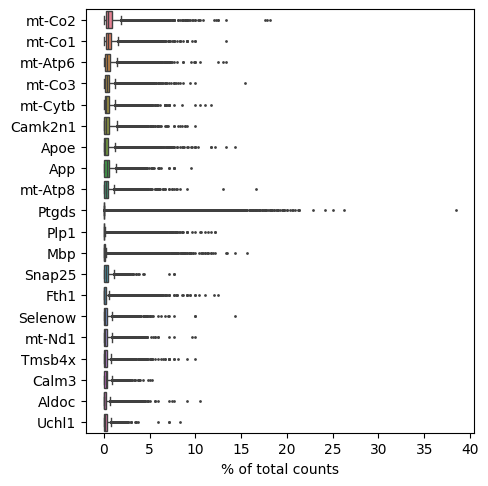

In [21]:
sc.pl.highest_expr_genes(adata_sc_final, n_top=20)

In [22]:
sc.pp.filter_cells(adata_sc_final, min_genes=20)
adata_sc_final

AnnData object with n_obs × n_vars = 37372 × 9970
    obs: 'cell_type', 'cos_simularity', 'n_counts', 'n_genes'
    var: 'gene_ids', 'feature_types'

In [23]:
# annotate the group of mitochondrial genes as "mt"
adata_sc_final.var["mt"] = adata_sc_final.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
   adata_sc_final, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

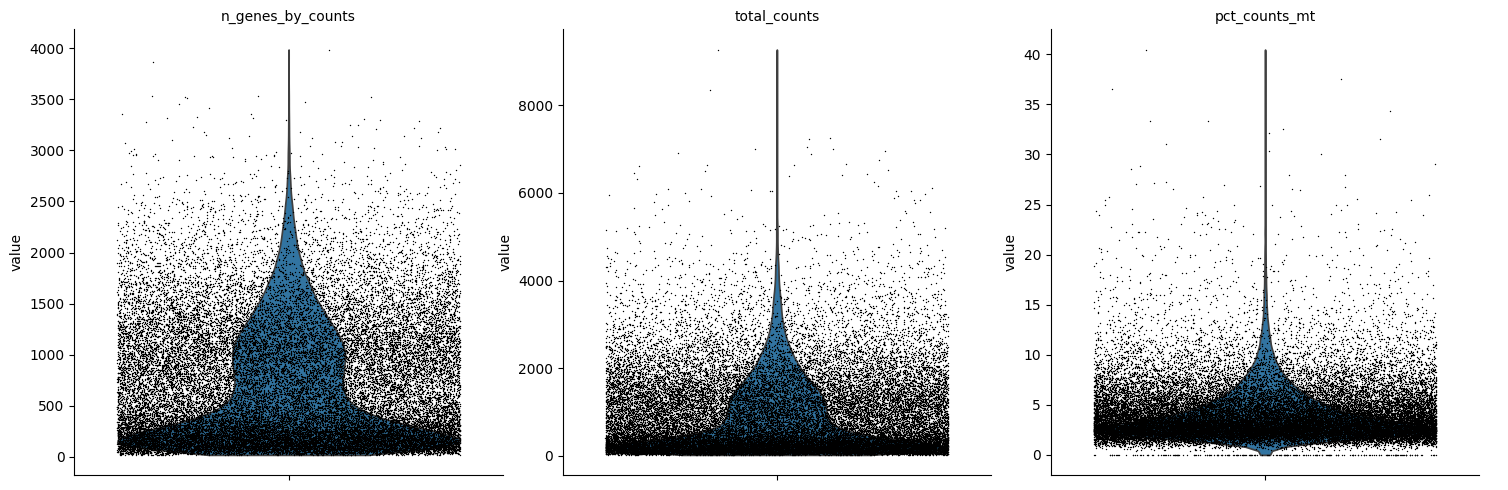

In [24]:
sc.pl.violin(
    adata_sc_final,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

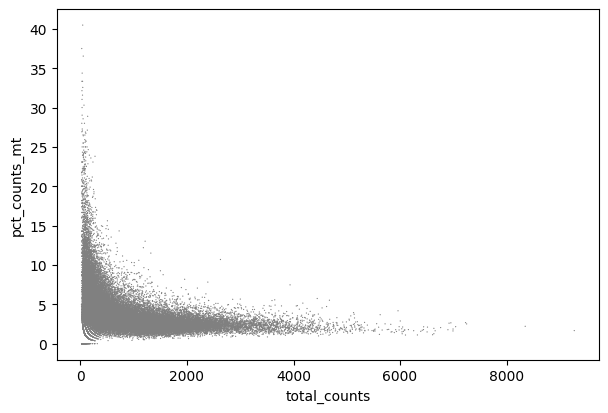

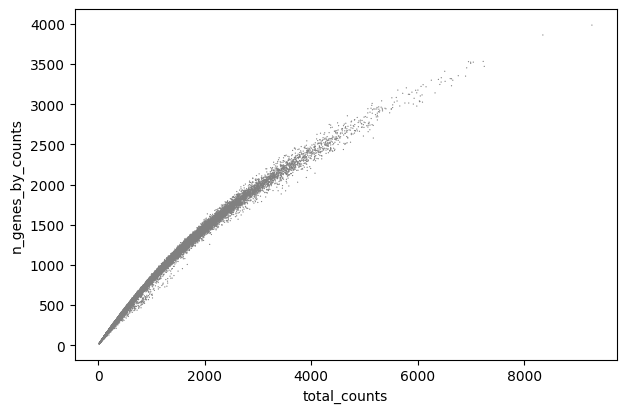

In [25]:
sc.pl.scatter(adata_sc_final, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata_sc_final, x="total_counts", y="n_genes_by_counts")

In [26]:
adata_sc_final = adata_sc_final[adata_sc_final.obs.n_genes_by_counts < 2000, :]
adata_sc_final = adata_sc_final[adata_sc_final.obs.pct_counts_mt < 20, :].copy()

In [27]:
sc.pp.normalize_total(adata_sc_final , target_sum=1e4)

In [28]:
sc.pp.log1p(adata_sc_final)

In [29]:
sc.pp.highly_variable_genes(adata_sc_final, min_mean=0.0125, max_mean=3, min_disp=0.5)

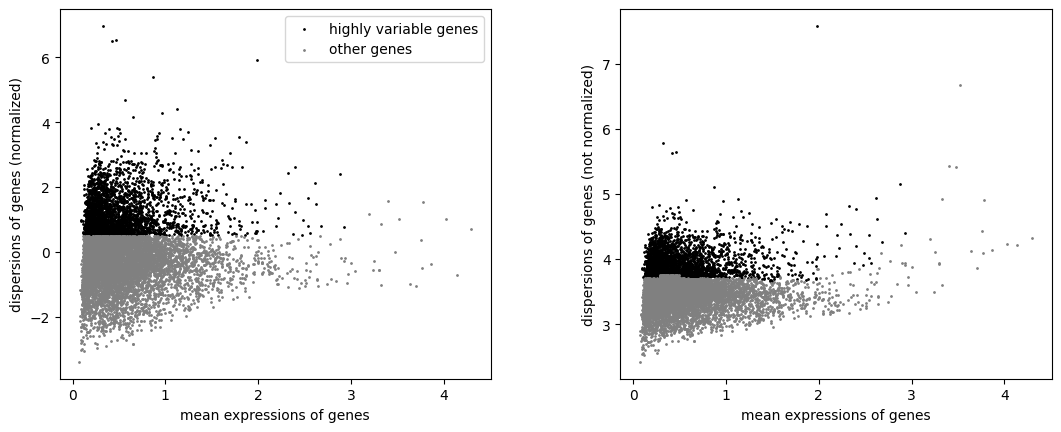

In [30]:
sc.pl.highly_variable_genes(adata_sc_final)

In [31]:
adata_sc_final.raw = adata_sc_final

In [32]:
adata_sc_final = adata_sc_final[:, adata_sc_final.var.highly_variable]

In [33]:
sc.pp.regress_out(adata_sc_final, ["total_counts", "pct_counts_mt"])

/home/juanru/miniconda3/envs/bidcell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:644: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [34]:
sc.pp.scale(adata_sc_final, max_value=10)

In [35]:
sc.tl.pca(adata_sc_final, svd_solver="arpack")

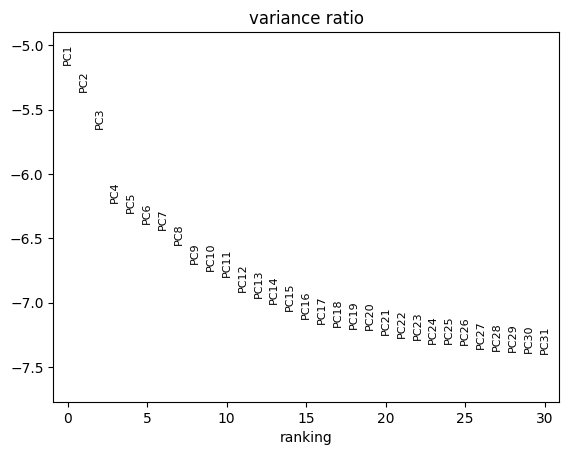

In [36]:
sc.pl.pca_variance_ratio(adata_sc_final, log=True)

In [37]:
sc.pp.neighbors(adata_sc_final, n_neighbors=10, n_pcs=40)

/home/juanru/miniconda3/envs/bidcell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
sc.tl.umap(adata_sc_final)

In [39]:
sc.tl.leiden(
    adata_sc_final,
    resolution=2,
    random_state=0,
    directed=False,
)

/tmp/ipykernel_573723/1921915662.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


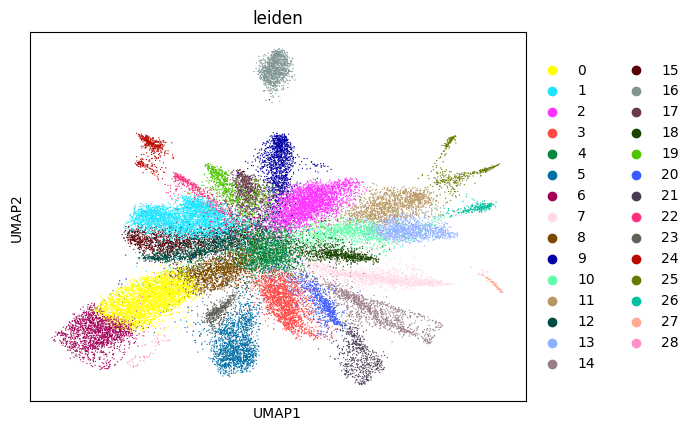

In [40]:
sc.pl.umap(adata_sc_final, color=["leiden"])

In [41]:
adata_sc_final.write('results_example/adata_sc_final_processed.h5ad')

In [42]:
with open("results_example/spot_cell_dic.pkl", 'wb') as f:
    pickle.dump(spot_cell_dic, f)